# Sinusoid Regression: Ablation Studies
Notebook to run subspace dimensionality and subspace complexity ablation experiments on the sinusoid dataset.

Before running this notebook, you need to follow the notebook `sinusoid-results.ipynb` to generate pretraining runs and calculate a preconditioning matrix.

In [114]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import sys
import os
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
from matplotlib import rc
from scipy.stats import ortho_group
from torch.nn.utils import parameters_to_vector
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot import plot, analyses
from tsfewshot.config import Config
from tsfewshot.models import get_model
from tsfewshot.pcautils import load_diffs
from tsfewshot.utils import load_model

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZE = 5
QUERY_SIZE = 100
MODEL_SIZE = 1761  # number of parameters in the 2-hidden-layer model

CODE_DIR = Path('../..')

rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# get the run directory from the meta-training phase
RUN = list(Path('runs/').glob(f'*maml-5support*'))[0].resolve()

In [129]:
ft_epochs = defaultdict(lambda: 200)

eval_every = list(range(20)) + list(range(20, 201, 10))
inner_seeds = [0]

type_specs = [
    'normal',  # SGD finetuning based on MAML initialization. Effectively, this is MAML.
    'pca',  # our method
    'pca-noweight',  # our method without weighting by eigenvalues
    'pca-random-noweight',  # random orthogonal directions instead of PCA directions
    'pca-diagonal-noweight',  # diagonal preconditioning matrix
]
def thresholds():
    return [1761, 512, 256, 64, 32, 8, 2]  # degrees of freedom

gridsearch_dir = 'optimizeFinetune_thresholdSweep'
test_tasks = ['0.1#5.0#0.0#3.141592654#-5.0#5.0']

def combinations(random=False, diagonal=False):
    combinations = []
    for type_spec in type_specs:
        if (random and 'random' not in type_spec) or (not random and 'random' in type_spec) \
                or (diagonal and 'diagonal' not in type_spec) or (not diagonal and 'diagonal' in type_spec):            continue
        if 'pca' in type_spec:
            lrs = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005]
        else:
            lrs = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
        t_sparsities = [('keep-n', n) for n in thresholds()]
        if type_spec in ['normal']:
            t_sparsities = [None]
        for lr in lrs:
            for sparsity in t_sparsities:
                combinations.append({'support': SUPPORT_SIZE,
                                     'lr': lr,
                                     'type': type_spec,
                                     'noise': 0.0,
                                     'sparsity': sparsity,
                                    })
    return combinations
    
len(combinations())

90

In [15]:
# Create a fake PCA file where the preconditioning matrix has the weight deltas on the diagonal and
# zeros elsewhere

# load weight differences
cfg = Config(RUN / 'config.yml')
cfg.update({'device': 'cpu'})
uninit_model = get_model(cfg, is_test=True, is_finetune=False)
init_model, _ = load_model(cfg, uninit_model, epoch=50000)
init_vector = parameters_to_vector(init_model.parameters()).detach().cpu()
finetune_runs = list((RUN / 'finetune_epoch50000').glob('sinus*'))
deltas = [load_diffs(cfg, run, copy.deepcopy(init_vector)) for run in finetune_runs]
deltas = torch.stack([vec for run_deltas in deltas for vec in run_deltas])

deltas = torch.sqrt(torch.mean(torch.square(deltas), dim=0))  # will be squared by PCAOptimizer again

# write deltas on the diagonal of the matrix.
# we sort the diagonal matrix, so we can use keep-n to cut off the lowest deltas
diag_deltas = torch.zeros((deltas.shape[0], deltas.shape[0]))
for i, (delta, orig_idx) in enumerate(zip(*torch.sort(deltas, descending=True))):
    diag_deltas[orig_idx, i] = delta

# s & u values don't matter because we won't use weighting, we just need their shape
model_dim = diag_deltas.shape[0]
deltas_pca = {'s': torch.ones((model_dim,)), 'v': diag_deltas, 'u': torch.ones((model_dim, model_dim))}
pickle.dump(deltas_pca, (RUN / 'pca/deltas_pca_sorted.p').open('wb'))

In [17]:
# create preconditioning matrix with random orthogonal vectors
torch.manual_seed(0)
np.random.seed(0)
random_orthogonal = torch.from_numpy(ortho_group.rvs(dim=MODEL_SIZE)).to(torch.float32)

# s & u values don't matter because we won't use weighting, we just need their shape
random_pca = {'s': torch.ones((MODEL_SIZE,)),
              'v': random_orthogonal,
              'u': torch.ones((MODEL_SIZE, MODEL_SIZE))}
pickle.dump(random_pca, (RUN / 'pca/random_pca_orthogonal.p').open('wb'))

In [122]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = []
cfg_update = {
    'batch_size': 64,
    'training_setup': 'supervised',
}
for method in [None, 'random', 'diagonal', 'path']:
    pca_file = RUN / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse-1761tasks.p'
    if method == 'random':
        pca_file = RUN / 'pca/random_pca_orthogonal.p'
    if method == 'diagonal':
        pca_file = RUN / 'pca/deltas_pca_sorted.p'
    new_runs += analyses.create_gridsearch_dirs(RUN,
                                                combinations(random=method=='random', 
                                                             diagonal=method=='diagonal'),
                                                gridsearch_dir,
                                                inner_seeds,
                                                n_trajectories=-1,
                                                query_size=QUERY_SIZE,
                                                ft_epochs=ft_epochs,
                                                eval_every=eval_every,
                                                save_predictions=False,
                                                optimizer='sgd-squared',
                                                val_datasets=test_tasks,
                                                n_dataset_evals=100,
                                                init_epoch=50000,
                                                tasks_ds_cfg=cfg_update,
                                                pca_file_path=pca_file)
[r.name for r in new_runs]

100%|██████████| 6/6 [00:00<00:00, 50.68it/s]


['support5_lr1.0_pca-path_sparseNone_noise0.0_seed0',
 'support5_lr0.5_pca-path_sparseNone_noise0.0_seed0',
 'support5_lr0.1_pca-path_sparseNone_noise0.0_seed0',
 'support5_lr0.05_pca-path_sparseNone_noise0.0_seed0',
 'support5_lr0.01_pca-path_sparseNone_noise0.0_seed0',
 'support5_lr0.005_pca-path_sparseNone_noise0.0_seed0']

Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_thresholdSweep/ --epoch 50000 --split val --gpu-ids 0 --runs-per-gpu 5`.

In [25]:
best_ft_options = {}
best_ft_epochs = {}
gridsearch_results = {}

In [123]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each support size and each method.
# For the best configuration of each support size and method, we create a final finetuning experiment
# that we'll use to analyze the results.
new_run_dirs = []
for method in [None, 'random', 'diagonal']:
    out = analyses.create_final_finetune_dirs([RUN],
                                          [SUPPORT_SIZE],
                                          combinations(random=method=='random', 
                                                       diagonal=method=='diagonal'),
                                          inner_seeds,
                                          gridsearch_dir,
                                          test_tasks,
                                          n_dataset_evals=200,
                                          best_ft_options=best_ft_options,
                                          best_ft_epochs=best_ft_epochs,
                                          n_results=100,
                                          metric_aggregation='mean',
                                          metric_name='mse')
    new_run_dirs += out[0]
    best_ft_options.update(out[1])
    best_ft_epochs.update(out[2])
    gridsearch_results.update(out[3])
[r.name for r in new_run_dirs]

5
support size: 5    normal noise 0.0                                                                 LR: 0.01   epochs: 110  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 1761)                                        LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 2)                                           LR: 0.1    epochs: 160  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 256)                                         LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 32)                                          LR: 0.5    epochs: 110  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 512)                                         LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 64)                                          LR: 0.5    epochs: 100  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 8)                                           LR: 0.5    epochs: 90  

support size: 5    normal noise 0.0                                                                 LR: 0.01   epochs: 110  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 1761)                                        LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 2)                                           LR: 0.1    epochs: 160  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 256)                                         LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 32)                                          LR: 0.5    epochs: 110  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 512)                                         LR: 0.5    epochs: 90   
support size: 5    pca noise 0.0  sparsity: ('keep-n', 64)                                          LR: 0.5    epochs: 100  
support size: 5    pca noise 0.0  sparsity: ('keep-n', 8)                                           LR: 0.5    epochs: 90   


['support5_lr0.1_pca-path_sparseNone_noise0.0_seed0']

Next, run the final finetuning experiments:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_thresholdSweep_finalFinetune/ --epoch 50000 --split test --gpu-ids 0 --runs-per-gpu 5`.

In [124]:
# load the result from final finetuning
metrics = None
metrics = analyses.get_final_metrics([RUN],
                                     noises=[0.0],
                                     support_sizes=[SUPPORT_SIZE],
                                     combinations=combinations() \
                                         + combinations(random=True) \
                                         + combinations(diagonal=True),
                                     best_ft_options=best_ft_options,
                                     inner_seeds=inner_seeds,
                                     query_size=QUERY_SIZE,
                                     n_trajectories=-1,
                                     test_tasks=test_tasks,
                                     gridsearch_dir=gridsearch_dir,
                                     init_epoch=50000,
                                     metrics=metrics,
                                     metric_name='mse',
                                     metric_file_name='mse',
                                     metric_aggregation='mean',
                                     no_ft_eval=False)

5


In [32]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUN / 'metrics_thresholdSweep.p').open('wb'))
pickle.dump(best_ft_options, (RUN / 'best_ft_options_thresholdSweep.p').open('wb'))
pickle.dump(best_ft_epochs, (RUN / 'best_ft_epochs_thresholdSweep.p').open('wb'))

In [125]:
df_norms = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).mean(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


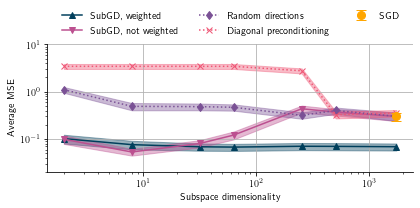

In [152]:
def plot_mse_vs_threshold(run_name, support, df, plot_fixed=[('normal noise 0.0 ', MODEL_SIZE)], ax=None):
    if ax is None:
        f, axs = plt.subplots(1, 1, figsize=(10,3))
        ax = axs[0]
        
    ax.set_xscale('log')
    all_thresholds = sorted(thresholds())

    vals = df.loc[:, (support, slice(None), slice(None))].groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))

    noise = 0.0
    for i, base_type in enumerate(type_specs):
        if base_type in ['normal']:
            continue
        typ_means = []
        cis = []
        type_thresholds = sorted(thresholds())
        for threshold in type_thresholds:
            type_name = f'{base_type} noise {noise}  sparsity: {("keep-n", threshold) if base_type != "deltas" else ("fraction", 1 - threshold/model_dim)}'
            typ_means.append(vals.loc[:, (support, type_name)].mean(skipna=False))
            typ_vals = df.loc[:, (support, slice(None), slice(None))].stack(level='seed').loc[:, (support, type_name)]
            ci = 1.96 * typ_vals.std() / np.sqrt(typ_vals.shape[0])
            ci_upper = typ_means[-1] + ci
            ci_lower = typ_means[-1] - ci
            cis.append([ci_lower, ci_upper])

        ls, col, label, marker = plot.get_style(type_name)
        style = {
            'normal': {'ls': '-', 'col': '#ffa600', 'marker': 'o', 'label': 'SGD'},
            'pca-noweight': {'ls': '-', 'col': '#bc5090', 'marker': 'v', 'label': 'SubGD, not weighted'},
            'pca-diagonal-noweight': {'ls': ':', 'col': '#ef5675', 'marker': 'x', 'label': 'Diagonal preconditioning'},
            'pca-random-noweight': {'ls': ':', 'col': '#7a5195', 'marker': 'd', 'label': 'Random directions'},
            'pca': {'ls': '-', 'col': '#003f5c', 'marker': '^', 'label': 'SubGD, weighted'},
        }
        ls = style[base_type].get('ls', ls)
        col = style[base_type].get('col', col)
        label = style[base_type].get('label', label)
        marker = style[base_type].get('marker', marker)

        ax.plot(np.array(type_thresholds), typ_means,
                ls=ls, label=label, c=col, marker=marker)
        ax.fill_between(np.array(type_thresholds),
                        np.array(cis)[:,0], np.array(cis)[:, 1],
                        color=col, alpha=0.4)

        ax.set_ylabel('Average MSE')

    for typ, degrees in plot_fixed:
        typ_means = vals.loc[:, (support, typ)].mean(skipna=False)
        typ_vals = df.loc[:, (support, slice(None), slice(None))].stack(level='seed').loc[:, (support, typ)]
        ci = 1.96 * typ_vals.std() / np.sqrt(typ_vals.shape[0])
        ls, col, label, marker = plot.get_style(typ)
        typ = typ.split(' noise')[0]
        ls = style[typ].get('ls', ls)
        col = style[typ].get('col', col)
        label = style[typ].get('label', label)
        marker = style[typ].get('marker', marker)
        
        ax.errorbar([degrees], typ_means, yerr=np.array([[ci, ci]]).T,
                ls=ls, label=label, c=col, marker=marker, ms=8, lw=0, capsize=5)

    ax.grid()
    ax.set_xlabel('Subspace dimensionality')
    ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5,1), ncol=3)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
f, axs = plt.subplots(1, 1, figsize=(6, 3), sharey=True)
i = 0
plot_mse_vs_threshold(RUN.name, SUPPORT_SIZE, df_norms, ax=axs)
i += 1
plt.ylim(2e-2, 10)
plt.yscale("log")
_ = plt.tight_layout()
plt.savefig('plots/sinus-epoch50000-subspacesize.pdf', bbox_inches='tight')

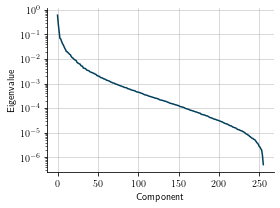

In [140]:
# Plot eigenvalue distribution
pca = pickle.load((RUN / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p').open('rb'))
eigenvalues = pca['s']**2 / (pca['u'].shape[0] - 1)
plt.figure(figsize=(4, 3))
plt.plot(eigenvalues, c='#003f5c')
plt.ylabel('Eigenvalue')
plt.xlabel('Component')
plt.grid(alpha=0.6)
plt.yscale('log')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('plots/sinus-epoch50000-eigenvalues.pdf', bbox_inches='tight')